# Calculating Polygenic Risk Scores per Group (23andMe AAC)
- **Project:** GP2 AFR-AAC meta-GWAS 
- **Version:** Python/3.9
- **Status:** COMPLETE
- **Started:** 25-FEB-2023
- **Last Updated:** 22-MAR-2023
    - **Update Description:** Run GLM 

## Notebook Overview
- Conducting PRS on cohorts: Pulling the 90 European variants from Nalls et al., 2019 and using AAC betas from 23andMe summary statistics

### CHANGELOG
- 25-FEB-2023: Notebook started 
- 22-MAR-2023: Run GLM

---
# Data Overview 

| ANCESTRY |     DATASET     | CASES | CONTROLS |  TOTAL  |           ARRAY           |                NOTES                |
|:--------:|:---------------:|:-----:|:--------:|:-------------------------:|:---------------------------------------------------------------------------------------------------------------:|:-----------------------------------:|
|    AFR   | IPDGC – Nigeria |  304  |    285   |   589   |         NeuroChip         | . | 
|    AFR   |  GP2  |  711  |   1,011  |  1,722  |        NeuroBooster       | . |
|    AAC   |  GP2 |  185  |   1,149  |  1,334  |        NeuroBooster       | . | 
|    AAC   |     23andMe     |  288  |  193,985 | 194,273 | Omni Express & GSA & 550k |        Just summary statistics       |

# Getting Started

## Importing packages

In [13]:
## Import the necessary packages 
import os
import numpy as np
import pandas as pd
import gwaslab as gl
import math
import sys
import subprocess
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numbers

## Print out package versions
## Getting packages loaded into this notebook and their versions to allow for reproducibility
    # Repurposed code from stackoverflow here: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

## Import packages 
import pkg_resources
import types
from datetime import date
today = date.today()
date = today.strftime("%d-%b-%Y").upper()

## Define function 
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different imported names vs. system/pip names
        # Unfortunately, there is no systematic way to get pip names from a package's imported name. You'll have to add exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

## Get a list of packages imported 
imports = list(set(get_imports()))

# The only way I found to get the version of the root package from only the name of the package is to cross-check the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

## Print out packages and versions 
print(f"PACKAGE VERSIONS ({date})")
for r in requirements:
    print("\t{}=={}".format(*r))

PACKAGE VERSIONS (22-MAR-2023)
	gwaslab==3.3.20
	matplotlib==3.5.3
	numpy==1.23.5
	pandas==1.5.3
	scikit-learn==1.2.2
	scipy==1.8.1
	seaborn==0.12.2
	statsmodels==0.13.5


# Define necessary functions

In [4]:
## Make a function to convert model to dataframe of values to print out 
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    stderr = results.bse
    # conf_lower = results.conf_int()[0]
    # conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"PVAL":pvals,
                               "BETA":coeff,
                               "STDERR":stderr
                               # "CONF_LOWER":conf_lower,
                               # "CONF_HIGHER":conf_higher
                                })

    # Calculate the odds ratios and the CIs 
    results_df['OR'] = results_df['BETA'].apply(np.exp)
    results_df['OR-95LOWERCI'] = results_df['OR'] - 1.96 * results_df['STDERR']
    results_df['OR-95UPPERCI'] = results_df['OR'] + 1.96 * results_df['STDERR']
    
    # Reordering...
    results_df = results_df[["PVAL","BETA", "STDERR", "OR", "OR-95LOWERCI", "OR-95UPPERCI"]].sort_values(by = 'PVAL')
    return results_df

## Extract the 90 variants from the 23andMe AAC summary statistics
- Find number of overlapping variants (77 out of 90 were found)
- Generate new score file

In [5]:
score_file = pd.read_csv(f"{WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt", sep="\t", header=None)
score_file.columns = ['markerID', 'META5_effect_allele', 'META5_beta']

aac_23andMe = pd.read_csv(f"{WORK_DIR}/data/23andMe/AAC_23andMe_MAF0.05.hg38.noindels.newMarkerIDs.tab", sep="\t", usecols=['markerID', 'effect_allele', 'effect'])
aac_23andMe.columns = ['markerID', '23andMeAAC_effect_allele', '23andMeAAC_beta']

In [ ]:
new_score_file = pd.merge(score_file, aac_23andMe, how="inner", on=['markerID'])
new_score_file

In [7]:
## Subset score file to use in PLINK 
new_score_file_subset = new_score_file[['markerID', '23andMeAAC_effect_allele', '23andMeAAC_beta']]
new_score_file_subset.to_csv(f"{WORK_DIR}/data/PRS/GP2_Nalls2019_variants_23andMe_betas_hg38.txt", index=False, header=None, sep="\t")

# IPDGC – Nigeria – AFR - NC

## Extract 77 variants + Calculate Scores

In [ ]:
%%bash

module load plink

plink2 \
--bfile ${NG_AFR_NEUROCHIP} \
--score ${WORK_DIR}/data/PRS/GP2_Nalls2019_variants_23andMe_betas_hg38.txt list-variants \
--out ${WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI-23andMeAACBETAS

## Calculate Dosages

In [ ]:
%%bash 

# Create transposed data with dosages

plink2 \
--bfile ${NG_AFR_NEUROCHIP} \
--extract ${WORK_DIR}/data/PRS/GP2_Nalls2019_variants_23andMe_betas_hg38.txt \
--export A --export-allele ${WORK_DIR}/data/PRS/GP2_Nalls2019_variants_23andMe_betas_hg38.txt \
--out ${WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI-23andMeAACBETAS-transpose

## Standardize + Visualize + Save PRS

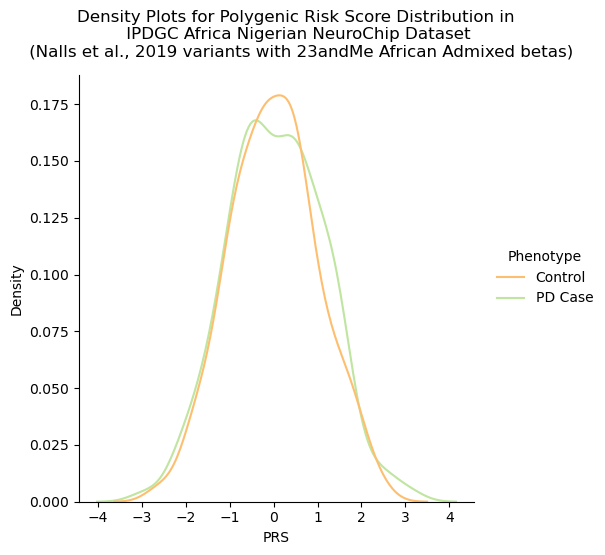

In [10]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI-23andMeAACBETAS.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
cov_df = pd.read_csv(f"{WORK_DIR}/data/AFR/NIGERIAN-NC/NIGERIAN-NEUROCHIP-AFR-covariate-wAGE-FEB2023.txt", sep="\t")
transpose_df = pd.read_csv(f"{WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI-23andMeAACBETAS-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")

# Standardize with the HC's distribution of PRS
hc_mean = np.mean(merged_df2[merged_df2.PHENO==1].PRS)
hc_sd = np.std(merged_df2[merged_df2.PHENO==1].PRS)
merged_df2['PRS'] = (merged_df2.PRS - hc_mean)/hc_sd
merged_df2.reset_index(inplace=True)

# Add case/control column for the legend
merged_df2['Phenotype'] = np.where(merged_df2['PHENO'] == 1, "Control", "PD Case")

## Plot PRS distribution 
g = sns.displot(merged_df2, x="PRS", hue="Phenotype", kind="kde", palette=sns.color_palette('Spectral', n_colors=2))
g.fig.suptitle('Density Plots for Polygenic Risk Score Distribution in \n IPDGC Africa Nigerian NeuroChip Dataset \n (Nalls et al., 2019 variants with 23andMe African Admixed betas)', y = 1.10)
g.savefig(f"{WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI-23andMeAACBETAS-PRS-Density.png", dpi=300)

## Save PRS 
prs_df.to_csv(f"{WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI-23andMeAACBETAS-PRS.csv",index=False)

## T-test

In [11]:
# PD vs healthy control
stats.ttest_ind(merged_df2.PRS[merged_df2.PHENO==2], merged_df2.PRS[merged_df2.PHENO==1])

Ttest_indResult(statistic=0.6230375369978738, pvalue=0.5335018352671709)

## Binomial GLM Regression

In [ ]:
# Keep only columns needed for regression
merged_df3 = merged_df2[['IID', 'PRS', 'SEX', 'PHENO', 'PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'AGE_ANALYSIS']].copy()

# Change pheno to 0/1
merged_df3['PHENO'] = merged_df3['PHENO'].replace({1: 0, 2: 1})

# Standardize continuous predictors by creating a z-score distribution
scaler = StandardScaler()
cols_to_standardize = ['PRS', 'AGE_ANALYSIS', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
merged_df3[cols_to_standardize] = scaler.fit_transform(merged_df3[cols_to_standardize])

# Binomial GLM to see if PRS predicts for PHENO (PD vs control)
formula = "PHENO ~ PRS + AGE_ANALYSIS + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
model = smf.glm(formula=formula, data=merged_df3, family=sm.families.Binomial(), missing='drop').fit()
print(model.summary())

# Get values
results_df = results_summary_to_dataframe(model)
results_df

In [15]:
results_df.loc[['PRS']]

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
PRS,0.91329,0.00974,0.08945,1.009788,0.834465,1.18511


## Results Summary 

<div class="alert alert-block alert-info">
<b>Results for IPDGC - Nigerian - NeuroChip:</b> 
<ul>
    <li>73 out of 77 variants were found</li>
    <li>T-test not significant between case and control PRS (P=0.5335)</li>
    <li>PRS does not predict status between PD and healthy controls (P=0.91329; BETA=0.00974; SE=0.08945; OR=1.009788; CI=0.834465-1.18511; GLM Binomial regression)</li>
</ul>
</div>

# GP2 – AFR (public AFR+Nigerian NB)

## Extract 77 variants + Calculate Scores

In [ ]:
%%bash

module load plink

plink2 \
--bfile ${UPDATED_GP2_v4_AFR} \
--score ${WORK_DIR}/data/PRS/GP2_Nalls2019_variants_23andMe_betas_hg38.txt list-variants \
--out ${WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI-23andMeAACBETAS

## Calculate Dosages

In [ ]:
%%bash 

# Create transposed data with dosages

plink2 \
--bfile ${UPDATED_GP2_v4_AFR} \
--extract ${WORK_DIR}/data/PRS/GP2_Nalls2019_variants_23andMe_betas_hg38.txt \
--export A --export-allele ${WORK_DIR}/data/PRS/GP2_Nalls2019_variants_23andMe_betas_hg38.txt \
--out ${WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI-23andMeAACBETAS-transpose

## Standardize + Visualize + Save PRS

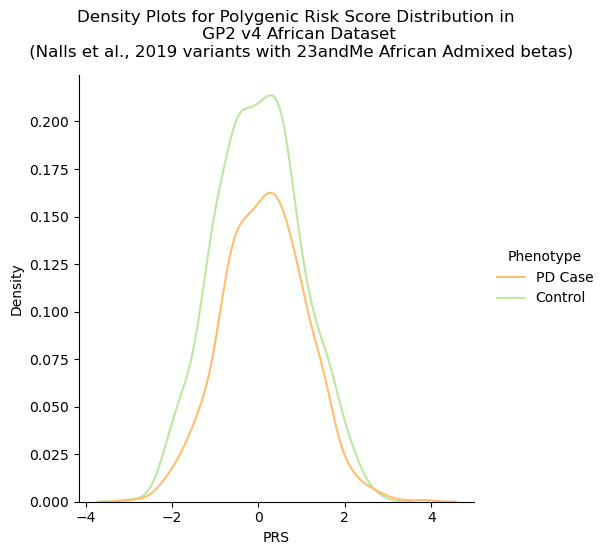

In [18]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI-23andMeAACBETAS.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
cov_df = pd.read_csv(f"{WORK_DIR}/data/masterfile_updated_GP2_v4_covariateFile_wAGE_FEB2023.txt", sep="\t")
transpose_df = pd.read_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI-23andMeAACBETAS-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")

# Standardize with the HC's distribution of PRS
hc_mean = np.mean(merged_df2[merged_df2.PHENO==1].PRS)
hc_sd = np.std(merged_df2[merged_df2.PHENO==1].PRS)
merged_df2['PRS'] = (merged_df2.PRS - hc_mean)/hc_sd
merged_df2.reset_index(inplace=True)

# Add case/control column for the legend
merged_df2['Phenotype'] = np.where(merged_df2['PHENO'] == 1, "Control", "PD Case")

## Plot PRS distribution 
g = sns.displot(merged_df2, x="PRS", hue="Phenotype", kind="kde", palette=sns.color_palette('Spectral', n_colors=2))
g.fig.suptitle('Density Plots for Polygenic Risk Score Distribution in \n GP2 v4 African Dataset \n (Nalls et al., 2019 variants with 23andMe African Admixed betas)', y = 1.10)
g.savefig(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI-23andMeAACBETAS-PRS-Density.png", dpi=300)

## Save PRS 
prs_df.to_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI-23andMeAACBETAS-PRS.csv",index=False)

## T-test

In [19]:
# PD vs healthy control
stats.ttest_ind(merged_df2.PRS[merged_df2.PHENO==2], merged_df2.PRS[merged_df2.PHENO==1])

Ttest_indResult(statistic=2.937029807543869, pvalue=0.003357783142980037)

## Binomial GLM Regression

In [ ]:
# Keep only columns needed for regression
merged_df3 = merged_df2[['IID', 'PRS', 'SEX', 'PHENO', 'PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'AGE_ANALYSIS']].copy()

# Change pheno to 0/1
merged_df3['PHENO'] = merged_df3['PHENO'].replace({1: 0, 2: 1})

# Standardize continuous predictors by creating a z-score distribution
scaler = StandardScaler()
cols_to_standardize = ['PRS', 'AGE_ANALYSIS', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
merged_df3[cols_to_standardize] = scaler.fit_transform(merged_df3[cols_to_standardize])

# Binomial GLM to see if PRS predicts for PHENO (PD vs control)
formula = "PHENO ~ PRS + AGE_ANALYSIS + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
model = smf.glm(formula=formula, data=merged_df3, family=sm.families.Binomial(), missing='drop').fit()
print(model.summary())

# Get values
results_df = results_summary_to_dataframe(model)
results_df

In [21]:
results_df.loc[['PRS']]

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
PRS,0.000019,0.236845,0.055372,1.267245,1.158715,1.375774


In [ ]:
## Recode status
merged_df2['STATUS'] = np.where(merged_df2['PHENO']==1, "CONTROL", "PD")
merged_df2['Sex'] = np.where(merged_df2['SEX']==1, "Male", "Female")

## Aggregate the information
pivot_df = merged_df2.loc[
    merged_df2.STATUS.isin(['CONTROL', 'PD']),
    ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains('^chr')])
].pivot_table(
    index=['STATUS'],
    aggfunc=['mean']
).T.reset_index().drop(columns='level_0').set_index('level_1')

## Calculate the frequency difference per variant between cases and controls
pivot_df['FREQ_DIFFERENCE'] = pivot_df['PD'] - pivot_df['CONTROL']

## Read in the full Nalls et al., scoring file
scores = pd.read_csv(f"{WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt", sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
scores.index = scores['SNP'] + '_' + scores['A1']

## Merge pivot table and scores file to calculate mean effect
snp_beta_df = pd.concat([scores,pivot_df],axis=1)
snp_beta_df['EFFECT_MEAN'] = snp_beta_df['FREQ_DIFFERENCE']*snp_beta_df['BETA']
snp_beta_df.sort_values('EFFECT_MEAN')

## Histogram Plot to Visualize Mean Effect

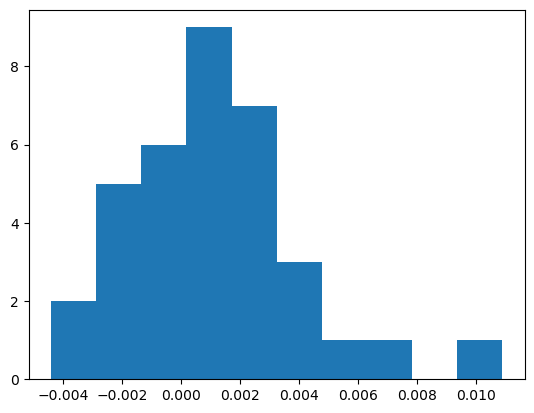

,SNP,A1,BETA,CONTROL,PD,FREQ_DIFFERENCE,EFFECT_MEAN


In [23]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()
snp_beta_df[snp_beta_df.EFFECT_MEAN>0.02]

## Results Summary 

<div class="alert alert-block alert-info">
<b>Results for GP2 – AFR:</b> 
<ul>
    <li>77 out of 77 variants were found</li>
    <li>T-test is significant between case and control PRS (P=0.003357)</li>
    <li>PRS does significantly predict status between PD and healthy controls (P=1.892E-05; BETA=0.236845; SE=0.055372; OR=1.267245; CI=1.158715-1.375774; GLM Binomial regression)</li>
    <li>No variants were found to drive the PRS prediction</li>
</ul>
</div>


# GP2 release 4 – AAC 

## Extract 77 variants + Calculate Scores

In [ ]:
%%bash

module load plink

plink2 \
--bfile ${UPDATED_GP2_v4_AAC} \
--score ${WORK_DIR}/data/PRS/GP2_Nalls2019_variants_23andMe_betas_hg38.txt list-variants \
--out ${WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI-23andMeAACBETAS

## Calculate Dosages

In [ ]:
%%bash 

# Create transposed data with dosages

plink2 \
--bfile ${UPDATED_GP2_v4_AAC} \
--extract ${WORK_DIR}/data/PRS/GP2_Nalls2019_variants_23andMe_betas_hg38.txt \
--export A --export-allele ${WORK_DIR}/data/PRS/GP2_Nalls2019_variants_23andMe_betas_hg38.txt \
--out ${WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI-23andMeAACBETAS-transpose

## Standardize + Visualize + Save PRS

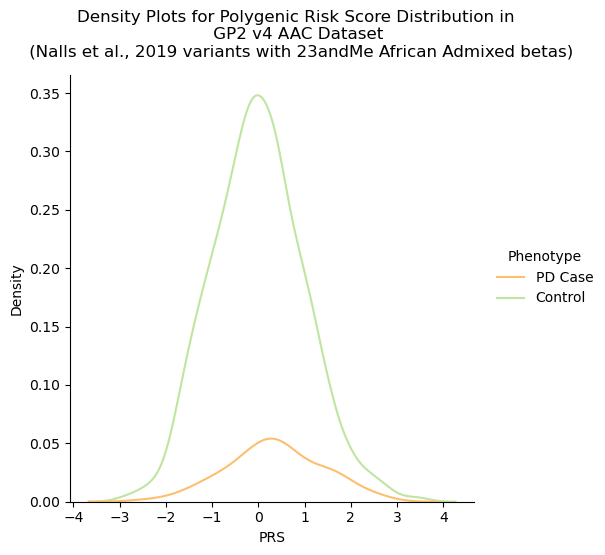

In [26]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI-23andMeAACBETAS.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
cov_df = pd.read_csv(f"{WORK_DIR}/data/masterfile_updated_GP2_v4_covariateFile_wAGE_FEB2023.txt", sep="\t")
transpose_df = pd.read_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI-23andMeAACBETAS-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")

# Standardize with the HC's distribution of PRS
hc_mean = np.mean(merged_df2[merged_df2.PHENO==1].PRS)
hc_sd = np.std(merged_df2[merged_df2.PHENO==1].PRS)
merged_df2['PRS'] = (merged_df2.PRS - hc_mean)/hc_sd
merged_df2.reset_index(inplace=True)

# Add case/control column for the legend
merged_df2['Phenotype'] = np.where(merged_df2['PHENO'] == 1, "Control", "PD Case")

## Plot PRS distribution 
g = sns.displot(merged_df2, x="PRS", hue="Phenotype", kind="kde", palette=sns.color_palette('Spectral', n_colors=2))
g.fig.suptitle('Density Plots for Polygenic Risk Score Distribution in \n GP2 v4 AAC Dataset \n (Nalls et al., 2019 variants with 23andMe African Admixed betas)', y = 1.10)
g.savefig(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI-23andMeAACBETAS-PRS-Density.png", dpi=300)

## Save PRS 
prs_df.to_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI-PRS.csv",index=False)

## T-test

In [27]:
# PD vs healthy control
stats.ttest_ind(merged_df2.PRS[merged_df2.PHENO==2], merged_df2.PRS[merged_df2.PHENO==1])

Ttest_indResult(statistic=4.475165496152798, pvalue=8.286536914586272e-06)

## Binomial GLM Regression

In [ ]:
# Keep only columns needed for regression
merged_df3 = merged_df2[['IID', 'PRS', 'SEX', 'PHENO', 'PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'AGE_ANALYSIS']].copy()

# Change pheno to 0/1
merged_df3['PHENO'] = merged_df3['PHENO'].replace({1: 0, 2: 1})

# Standardize continuous predictors by creating a z-score distribution
scaler = StandardScaler()
cols_to_standardize = ['PRS', 'AGE_ANALYSIS', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
merged_df3[cols_to_standardize] = scaler.fit_transform(merged_df3[cols_to_standardize])

# Binomial GLM to see if PRS predicts for PHENO (PD vs control)
formula = "PHENO ~ PRS + AGE_ANALYSIS + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
model = smf.glm(formula=formula, data=merged_df3, family=sm.families.Binomial(), missing='drop').fit()
print(model.summary())

# Get values
results_df = results_summary_to_dataframe(model)
results_df

In [29]:
results_df.loc[['PRS']]

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
PRS,0.000067,0.356079,0.089279,1.42772,1.252733,1.602708


In [ ]:
## Recode status
merged_df2['STATUS'] = np.where(merged_df2['PHENO']==1, "CONTROL", "PD")
merged_df2['Sex'] = np.where(merged_df2['SEX']==1, "Male", "Female")

## Aggregate the information
pivot_df = merged_df2.loc[
    merged_df2.STATUS.isin(['CONTROL', 'PD']),
    ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains('^chr')])
].pivot_table(
    index=['STATUS'],
    aggfunc=['mean']
).T.reset_index().drop(columns='level_0').set_index('level_1')

## Calculate the frequency difference per variant between cases and controls
pivot_df['FREQ_DIFFERENCE'] = pivot_df['PD'] - pivot_df['CONTROL']

## Read in the full Nalls et al., scoring file
scores = pd.read_csv(f"{WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt", sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
scores.index = scores['SNP'] + '_' + scores['A1']

## Merge pivot table and scores file to calculate mean effect
snp_beta_df = pd.concat([scores,pivot_df],axis=1)
snp_beta_df['EFFECT_MEAN'] = snp_beta_df['FREQ_DIFFERENCE']*snp_beta_df['BETA']
snp_beta_df.sort_values('EFFECT_MEAN')

## Histogram Plot to Visualize Mean Effect

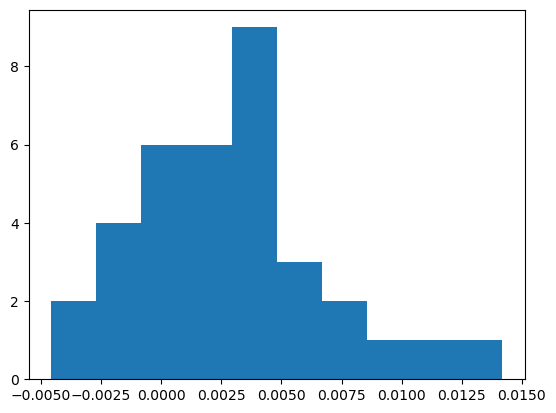

,SNP,A1,BETA,CONTROL,PD,FREQ_DIFFERENCE,EFFECT_MEAN


In [31]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()
snp_beta_df[snp_beta_df.EFFECT_MEAN>0.02]

## Results Summary 

<div class="alert alert-block alert-info">
<b>Results for GP2 – AAC:</b> 
<ul>
    <li>77 out of 77 variants were found</li>
    <li>T-test is significant between case and control PRS (P=8.287E-06)</li>
    <li>PRS does significantly predict status between PD and healthy controls (P=6.653E-05; BETA=0.356079; SE=0.089279; OR=1.42772; CI=1.252733-1.602708;  GLM Binomial regression)</li>
    <li>No variants were found to drive the PRS prediction</li>
</ul>
</div>